In [1]:
###Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import spacy
from pysentimiento import create_analyzer
import seaborn as sns

QUERY a utilizar: "plebiscito constitucional chile until:2020-10-31 since:2020-08-01 -filter:links"

In [ ]:
df = pd.read_csv("data/raw/tweets_plebiscito_2020.csv")
df.head()

In [ ]:
df.sort_values(ascending=False, by=["Likes"])

#### Creación nuevo DataFrame
Creamos un nuevo dataframe llamado clean_df con las columnas "Tweet Content", "Views", "Likes", "Retweets", "Replies" y lo ordenamos por cantidad de likes (Por comodidad) 

In [38]:
clean_df = df[["Tweet Content", "Views", "Likes", "Retweets", "Replies"]]
clean_df = clean_df.sort_values(ascending=False, by=["Likes"], ignore_index=True)
clean_df.drop(0, inplace=True) #Elimino un tweet "colado"
clean_df.head()

,Tweet Content,Views,Likes,Retweets,Replies
1,A vitória do “sim” hoje no plebiscito pela ref...,0,12582,1612,410
2,Chile aprueba en plebiscito histórico cambiar ...,0,11307,4192,235
3,stop scrolling and say one word in spanish,605852,9722,2314,5505
4,"ÚLTIMA HORA | Con el 99,3% de las mesas escru...",0,8553,2654,140
5,Chile aprueba en plebiscito histórico cambiar ...,0,7700,2591,132


### Analisis
Ahora con el dataframe un poco mas ordenado podemos pasar a la fase de analisis 

In [41]:
lista_tweets = clean_df["Tweet Content"].tolist() #Creo una lista con los tweets

In [51]:
stop_words = set(stopwords.words('spanish')) | {'rt','via','https','http'} #Genero la lista de stop_words

In [52]:
nlp = spacy.load("es_core_news_sm") #Cargo español en spacy

In [53]:
lista_sin_stopwords = []
for tweet in lista_tweets:
    new_tweet = ""
    doc = nlp(tweet)
    lemmas = [token.lemma_.lower() for token in doc] #Tokenizo el tweet en la variable lemmas
    for word in lemmas:
        if word not in stop_words:
            new_tweet += word #Añado cada palabra que no sea un stop word
            new_tweet+= " " #Añao un espacio para saparar las palabras
    lista_sin_stopwords.append(new_tweet) #Lista con los tweets sin los stopwords 

In [57]:
analyzer = create_analyzer(task="sentiment", lang="es") #Creo el analizador de sentimiento con el lenguanje en español

Vamos a analizar el sentimiento de cada tweets y a partir de esto vamos a crear 4 listas que despues agregaremos al dataframe

In [ ]:
POS = []
NEU = [] 
NEG = []
Output = []
for tweet in lista_sin_stopwords:
    analisis = analyzer.predict(tweet)
    pos = analisis.probas.get("POS")
    neu = analisis.probas.get("NEU")
    neg = analisis.probas.get("NEG")
    output = analisis.output
    POS.append(pos)
    NEU.append(neu)
    NEG.append(neg)
    Output.append(output)
    

In [63]:
clean_df["POS"] = POS
clean_df["NEU"] = NEU
clean_df["NEG"] = NEG
clean_df["output"] = Output
clean_df.head()

,Tweet Content,Views,Likes,Retweets,Replies,POS,NEU,NEG,output
1,A vitória do “sim” hoje no plebiscito pela ref...,0,12582,1612,410,0.153817,0.253931,0.592252,NEG
2,Chile aprueba en plebiscito histórico cambiar ...,0,11307,4192,235,0.210302,0.594206,0.195492,NEU
3,stop scrolling and say one word in spanish,605852,9722,2314,5505,0.063820,0.392795,0.543385,NEG
4,"ÚLTIMA HORA | Con el 99,3% de las mesas escru...",0,8553,2654,140,0.039805,0.477916,0.482279,NEG
5,Chile aprueba en plebiscito histórico cambiar ...,0,7700,2591,132,0.210302,0.594206,0.195492,NEU


Ya tenemos el dataframe con los tweets, ahora vamos a hacer un analisis superficial

In [68]:
concurrencia = clean_df["output"].value_counts()
print(concurrencia)

output
NEU    458
NEG    108
POS     21
Name: count, dtype: int64


Notamos que la gran mayoria de los tweets son Neutral, lo que es un resultado esperable. Tambien vemos que los tweets con una tendencia negativa superan por una amplia mayoria a los positivos.

In [70]:
df_neg_pos = clean_df[clean_df['output'].isin(['NEG', 'POS'])]
df_neg_pos.head()

,Tweet Content,Views,Likes,Retweets,Replies,POS,NEU,NEG,output
1,A vitória do “sim” hoje no plebiscito pela ref...,0,12582,1612,410,0.153817,0.253931,0.592252,NEG
3,stop scrolling and say one word in spanish,605852,9722,2314,5505,0.063820,0.392795,0.543385,NEG
4,"ÚLTIMA HORA | Con el 99,3% de las mesas escru...",0,8553,2654,140,0.039805,0.477916,0.482279,NEG
6,Another historic victory for the people of Lat...,0,7553,2834,184,0.291808,0.276627,0.431565,NEG
8,"Salute to Santiago, Chile. Another incredible ...",61743,4205,470,104,0.816824,0.139269,0.043907,POS


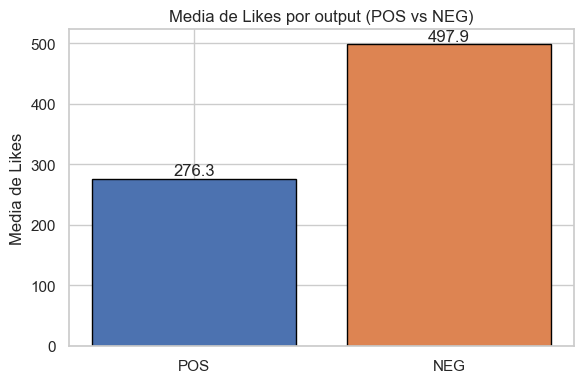

In [80]:
df2 = df_neg_pos[df_neg_pos['output'].isin(['POS', 'NEG'])].copy()
df2['Likes'] = pd.to_numeric(df2['Likes'], errors='coerce')
df2 = df2.dropna(subset=['Likes'])

# Calcular la media de Likes por grupo
mean_likes = df2.groupby('output')['Likes'].mean().loc[['POS', 'NEG']]

plt.figure(figsize=(6,4))
bars = plt.bar(mean_likes.index, mean_likes.values, color=['#4c72b0', '#dd8452'], edgecolor='black')
plt.ylabel('Media de Likes')
plt.title('Media de Likes por output (POS vs NEG)')

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, f'{h:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

por el grafico podemos concluir que los post con un sentimiento negativo suelen tener mas interacciones.